### Background checks

This nootebook tests the sampling of the background. We simulate only the background and we then fit it, leaving the tilt and normalization parameters free to vary.

In [2]:
cd ..

/Users/fabio/LAVORO/CTA/GAMMAPY/GIT/gammapy-benchmarks/validation/event-sampling


In [3]:
import make

In [1]:
from pathlib import Path
import logging
import warnings
import click
import multiprocessing
from itertools import repeat

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.convolution import Tophat2DKernel
from astropy.coordinates import SkyCoord
from astropy.table import Table
from gammapy.data import GTI, Observation, EventList
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.estimators import LiMaMapEstimator as lima
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.irf import EnergyDispersion2D, load_cta_irfs
from gammapy.makers import MapDatasetMaker
from gammapy.estimators import ImageProfile, ImageProfileEstimator
from gammapy.modeling import Fit
from gammapy.modeling.models import Models
from gammapy.utils.table import table_from_row_data
from regions import CircleSkyRegion

from gammapy.modeling.models import Model, Models, SkyModel, PowerLawSpectralModel, PointSpatialModel

import copy
from gammapy.maps import MapCoord
from gammapy.modeling.models import BackgroundModel, ConstantTemporalModel, LightCurveTemplateTemporalModel
from gammapy.utils.random import get_random_state
import yaml

from astropy.time import Time
from gammapy.utils.random import InverseCDFSampler


In [4]:
BASE_PATH = Path("make.py").parent

In [5]:
model="point-pwl-time"
LIVETIME = 8 * u.hr
filename_dataset = make.get_filename_dataset(LIVETIME)
filename_model =  BASE_PATH / f"models/{model}.yaml"

### SIMULATE THE EVENTS

In [6]:
make.simulate_events(filename_model,filename_dataset,100)

### COMPARE EVENT TIMES WITH THE SIMULATED LIGHT CURVE

In [9]:
model = 'point-pwl-time'
obsid=0
filename_events = (BASE_PATH / f"data/models/{model}/events_{LIVETIME.value:.0f}{LIVETIME.unit}_{obsid:04d}.fits.gz")
events = EventList.read(filename_events)

In [10]:
src = events.table[np.where(events.table['MC_ID'] == 2)]

In [11]:
len(src)

16988

In [12]:
times = src['TIME']

/anaconda2/envs/gammapy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


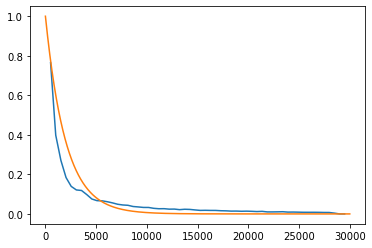

In [15]:
# curve = np.histogram(times,bins=np.logspace(2,4.5,30))
curve = np.histogram(times, bins=np.linspace(0,3e4,60))

rate = curve[0]/np.linspace(0,3e4,60)[:-1]

plt.plot(curve[1][:-1],rate)
plt.plot(time,norm)
# plt.loglog()

In [16]:
def f(x, a, tau,c):
    return c+a*np.exp(-(x/tau))

In [17]:
from scipy.optimize import curve_fit

init_vals = [1, 2000, 0]
best_vals, covar = curve_fit(f, curve[1][1:-4], 
                             rate[1:-3], 
                             p0=init_vals, 
                             sigma=((curve[0][1:-3])**0.5/np.linspace(0,3e4,60)[1:-4]))

print("############")
print(f"This is the norm: {best_vals[0]} +\- {covar[0,0]**0.5}")
print(f"This is the tau: {best_vals[1]} +\- {covar[1,1]**0.5}")
print(f"This is the constant: {best_vals[2]} +\- {covar[2,2]**0.5}")
print("############")

############
This is the norm: 0.2263995749254916 +\- 0.021195737977578344
This is the tau: 4547.594551342715 +\- 284.8292066169259
This is the constant: 0.008640578695136267 +\- 0.0006598713721083435
############


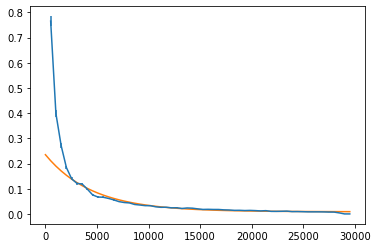

In [18]:
plt.errorbar(curve[1][:-1],rate, yerr=((curve[0])**0.5/np.linspace(0,3e4,60)[1:]))
plt.plot(curve[1][:-1], f(curve[1][:-1], *best_vals))

#### Check metadata

In [25]:
class EventListChecker(Checker):
    """Event list checker.

    Data format specification: ref:`gadf:iact-events`

    Parameters
    ----------
    event_list : `~gammapy.data.EventList`
        Event list
    """

    def __init__(self, Checker):
        self.Checker = Checker    

    CHECKS = {
        "meta": "check_meta",
        "columns": "check_columns",
        "times": "check_times",
        "coordinates_galactic": "check_coordinates_galactic",
        "coordinates_altaz": "check_coordinates_altaz",
    }

    accuracy = {"angle": Angle("1 arcsec"), "time": Quantity(1, "microsecond")}

    # https://gamma-astro-data-formats.readthedocs.io/en/latest/events/events.html#mandatory-header-keywords
    meta_required = [
        "HDUCLASS",
        "HDUDOC",
        "HDUVERS",
        "HDUCLAS1",
        "OBS_ID",
        "TSTART",
        "TSTOP",
        "ONTIME",
        "LIVETIME",
        "DEADC",
        "RA_PNT",
        "DEC_PNT",
        # TODO: what to do about these?
        # They are currently listed as required in the spec,
        # but I think we should just require ICRS and those
        # are irrelevant, should not be used.
        # 'RADECSYS',
        # 'EQUINOX',
        "ORIGIN",
        "TELESCOP",
        "INSTRUME",
        "CREATOR",
        # https://gamma-astro-data-formats.readthedocs.io/en/latest/general/time.html#time-formats
        "MJDREFI",
        "MJDREFF",
        "TIMEUNIT",
        "TIMESYS",
        "TIMEREF",
        # https://gamma-astro-data-formats.readthedocs.io/en/latest/general/coordinates.html#coords-location
        "GEOLON",
        "GEOLAT",
        "ALTITUDE",
    ]

    _col = collections.namedtuple("col", ["name", "unit"])
    columns_required = [
        _col(name="EVENT_ID", unit=""),
        _col(name="TIME", unit="s"),
        _col(name="RA", unit="deg"),
        _col(name="DEC", unit="deg"),
        _col(name="ENERGY", unit="TeV"),
    ]

    def __init__(self, event_list):
        self.event_list = event_list

    def _record(self, level="info", msg=None):
        obs_id = self.event_list.table.meta["OBS_ID"]
        return {"level": level, "obs_id": obs_id, "msg": msg}

    def check_meta(self):
        meta_missing = sorted(set(self.meta_required) - set(self.event_list.table.meta))
        if meta_missing:
            yield self._record(
                level="error", msg=f"Missing meta keys: {meta_missing!r}"
            )

    def check_columns(self):
        t = self.event_list.table

        if len(t) == 0:
            yield self._record(level="error", msg="Events table has zero rows")

        for name, unit in self.columns_required:
            if name not in t.colnames:
                yield self._record(level="error", msg=f"Missing table column: {name!r}")
            else:
                if Unit(unit) != (t[name].unit or ""):
                    yield self._record(
                        level="error", msg=f"Invalid unit for column: {name!r}"
                    )

    def check_times(self):
        dt = (self.event_list.time - self.event_list.observation_time_start).sec
        if dt.min() < self.accuracy["time"].to_value("s"):
            yield self._record(level="error", msg="Event times before obs start time")

        dt = (self.event_list.time - self.event_list.observation_time_end).sec
        if dt.max() > self.accuracy["time"].to_value("s"):
            yield self._record(level="error", msg="Event times after the obs end time")

        if np.min(np.diff(dt)) <= 0:
            yield self._record(level="error", msg="Events are not time-ordered.")

    def check_coordinates_galactic(self):
        """Check if RA / DEC matches GLON / GLAT."""
        t = self.event_list.table

        if "GLON" not in t.colnames:
            return

        galactic = SkyCoord(t["GLON"], t["GLAT"], unit="deg", frame="galactic")
        separation = self.event_list.radec.separation(galactic).to("arcsec")
        if separation.max() > self.accuracy["angle"]:
            yield self._record(
                level="error", msg="GLON / GLAT not consistent with RA / DEC"
            )

    def check_coordinates_altaz(self):
        """Check if ALT / AZ matches RA / DEC."""
        t = self.event_list.table

        if "AZ" not in t.colnames:
            return

        altaz_astropy = self.event_list.altaz
        separation = angular_separation(
            altaz_astropy.data.lon,
            altaz_astropy.data.lat,
            t["AZ"].quantity,
            t["ALT"].quantity,
        )
        if separation.max() > self.accuracy["angle"]:
            yield self._record(
                level="error", msg="ALT / AZ not consistent with RA / DEC"
            )


NameError: name 'Checker' is not defined

In [26]:
from gammapy.data import EventList, EventListBase

In [38]:
r = EventListBase(filename_events)
evt = r.read(filename_events)

In [52]:
tab = EventList.read(filename_events)

In [53]:
tab.check()

<generator object Checker.run at 0x125204e58>

### TOOLS

#### Create the skymodel

In [21]:
spectral_model = PowerLawSpectralModel(index=2,amplitude="1e-12 TeV-1 cm-2 s-1", reference='1 TeV')

In [22]:
spatial_model = PointSpatialModel(lon_0= "0 deg", lat_0="0 deg", frame='galactic')

In [23]:
sky_model = SkyModel(spectral_model=spectral_model, spatial_model=spatial_model)

In [25]:
print(sky_model.temporal_model)

None


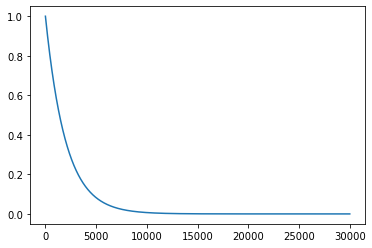

In [14]:
def rate(x, c="2e3 s"):
    c = u.Quantity(c)
    return np.exp(-x / c)


time = np.arange(3e4) * u.s
norm = rate(time)
plt.plot(time,norm)
# plt.loglog()
# plt.ylim(1e-1,1.1)

In [89]:
table = Table()
table["TIME"] = time
table["NORM"] = norm
table.meta = dict(MJDREFI=55197.0, MJDREFF=0, TIMEUNIT="s")
temporal_model = LightCurveTemplateTemporalModel(table)

filename = BASE_PATH / "models/lc.fits"
temporal_model.write(path=filename, overwrite=True)

In [90]:
sky_model = SkyModel(spectral_model=spectral_model, spatial_model=spatial_model, temporal_model=temporal_model)

In [91]:
models = Models([sky_model])

In [92]:
file_model = (BASE_PATH / "models/point-pwl-time.yaml")
models.write(file_model, overwrite=True)

#### TEST

In [93]:
filename_dataset = BASE_PATH / "data/dataset_8h.fits.gz"
dataset = MapDataset.read(filename_dataset)

In [95]:
filename_model = BASE_PATH / "models/point-pwl-time.yaml"
models = Models.read(filename_model)
dataset.models.extend(models)
model=dataset.models[1]
evaluator = dataset.evaluators.get(model.name)
evaluator = copy.deepcopy(evaluator)
evaluator.model.apply_irf["psf"] = False
evaluator.model.apply_irf["edisp"] = False
npred = evaluator.compute_npred()


In [96]:
temporal_model = dataset.models[1].temporal_model

In [97]:
print(temporal_model)

LightCurveTemplateTemporalModel model summary:
Start time: 55197.0 MJD
End time: 55197.34721064815 MJD
Norm min: 3.060553099062407e-07
Norm max: 1.0



In [98]:
obsid=0
irfs = load_cta_irfs(make.IRF_FILE)
observation = Observation.create(
    obs_id=obsid, pointing=make.POINTING, livetime=make.LIVETIME, irfs=irfs
)

sampler = MapDatasetEventSampler(random_state=0)

In [99]:
n_events = sampler.random_state.poisson(np.sum(npred.data))

coords = npred.sample_coord(n_events=n_events, random_state=sampler.random_state)

In [100]:
table = Table()
try:
    energy = coords["energy_true"]
except KeyError:
    energy = coords["energy"]

table["ENERGY_TRUE"] = energy
table["RA_TRUE"] = coords.skycoord.icrs.ra.to("deg")
table["DEC_TRUE"] = coords.skycoord.icrs.dec.to("deg")

In [101]:
time_start, time_stop, time_ref = (dataset.gti.time_start, dataset.gti.time_stop, dataset.gti.time_ref)

In [117]:
time = temporal_model.sample_time(
    n_events=n_events, t_min=time_start, t_max=time_stop, t_delta='100 s', random_state=sampler.random_state
)
table["TIME"] = u.Quantity(((time.mjd - time_ref.mjd) * u.day).to(u.s)).to("s")

In [126]:
min(table["TIME"]), max(table["TIME"])/500

(0.0, 57.40000000018627)

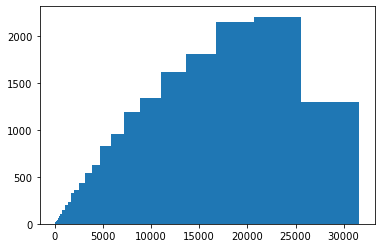

In [142]:
lc = plt.hist(np.sort(table["TIME"]), bins=np.logspace(0,4.5,50))
# plt.loglog()

In [144]:
np.logspace(0,4.5,50)

array([1.00000000e+00, 1.23548289e+00, 1.52641797e+00, 1.88586328e+00,
       2.32995181e+00, 2.87861559e+00, 3.55648031e+00, 4.39397056e+00,
       5.42867544e+00, 6.70703561e+00, 8.28642773e+00, 1.02377397e+01,
       1.26485522e+01, 1.56270698e+01, 1.93069773e+01, 2.38534401e+01,
       2.94705170e+01, 3.64103195e+01, 4.49843267e+01, 5.55773659e+01,
       6.86648845e+01, 8.48342898e+01, 1.04811313e+02, 1.29492584e+02,
       1.59985872e+02, 1.97659807e+02, 2.44205309e+02, 3.01711481e+02,
       3.72759372e+02, 4.60537826e+02, 5.68986603e+02, 7.02973212e+02,
       8.68511374e+02, 1.07303094e+03, 1.32571137e+03, 1.63789371e+03,
       2.02358965e+03, 2.50011038e+03, 3.08884360e+03, 3.81621341e+03,
       4.71486636e+03, 5.82513671e+03, 7.19685673e+03, 8.89159334e+03,
       1.09854114e+04, 1.35722878e+04, 1.67683294e+04, 2.07169840e+04,
       2.55954792e+04, 3.16227766e+04])

[]

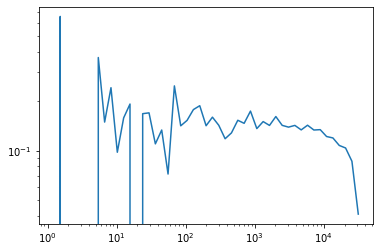

In [145]:
plt.plot(lc[1][1:],lc[0]/np.logspace(0,4.5,50)[1:])
plt.loglog()

In [63]:
t_delta='1 s'
time_unit = getattr(u, temporal_model.table.meta["TIMEUNIT"])

t_min = Time(dataset.gti.time_start)
t_max = Time(dataset.gti.time_stop)
t_delta = u.Quantity(t_delta)
random_state = get_random_state(0)

ontime = u.Quantity((t_max - t_min).sec, "s")
t_stop = ontime.to_value(time_unit)

In [64]:
# TODO: the separate time unit handling is unfortunate, but the quantity support for np.arange and np.interp
#  is still incomplete, refactor once we change to recent numpy and astropy versions
t_step = t_delta.to_value(time_unit)
t = np.arange(0, t_stop, t_step)

In [67]:
pdf = temporal_model.evaluate(t)

In [70]:
sampler = InverseCDFSampler(pdf=pdf, random_state=random_state)
time_pix = sampler.sample(n_events)[0]
time = np.interp(time_pix, np.arange(len(t)), t) * time_unit

In [71]:
tempo = t_min+time

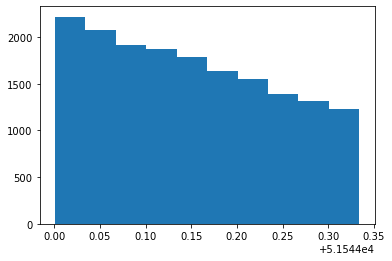

In [79]:
a=plt.hist(tempo.value)

In [4]:
IRF_FILE = "/Users/fabio/LAVORO/CTA/ACDC_ASTRI/ACDC1.1/ACDC1.1_ma9a/caldb/data/cta/prod3b/bcf/Astri_50h_June/irf_file.fits"
irfs = load_cta_irfs(IRF_FILE)

In [5]:
aeff=irfs['aeff'] 

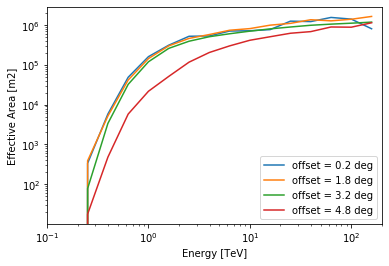

In [14]:
aeff.plot_energy_dependence()
plt.loglog()
plt.xlim(0.1,200)
plt.legend(loc='lower right')

In [21]:
aeff.plot()
plt.xlim(0.1,200)
plt.savefig("/Users/fabio/Articles/MNRAS/ACDC/JoHEA/REVISION/ASTRI_eff.png", dpi=300)
plt.clf()
plt.close()